In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
import joblib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## Data Loading

In [2]:

# Carga de los datos
data_path = '/Users/fernandopradagorge/Documents/Documentos - MacBook Pro de Fernando/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24/ML_Time_Series/ts_kaggle_train.csv'  # Asegúrate de tener la ruta correcta al archivo
df = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
df.head()


,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [3]:
# Información general del DataFrame
df.info()

# Estadísticas descriptivas
df.describe()

# Verificación de valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB


Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [4]:
# Cambio la fecha a un formato adecuado para trabajar con ella
df["date"] = pd.to_datetime(df["date"], format= "%Y-%m-%d")

In [5]:
# Voy a comprobar cuantas series temporales tiene el dataset:
df["unique_id"].nunique()

426

In [6]:
# Ahora cuantos meses
len(df["date"].unique())

34

In [7]:
df.shape

(14484, 9)

In [8]:
# Una vez comprobados los demás elementos , voy a ver cuales son las fechas mínimas y máximas del dataset:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [9]:
# Vuelvo a comprobar los nulos que tengo en el dataset
df.isnull().sum()

Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

## Data Imputation

In [10]:
# Procedo a rellenar los valores NaN con 0
df.fillna({"monthly_sales":0}, inplace=True)

In [11]:
df["monthly_average_price"] = df.groupby("unique_id")["monthly_average_price"].transform(
    lambda x: x.ffill().bfill()
)

In [12]:
# Compruebo si he imputado los nulos correctamente
df.isnull().sum()

Unnamed: 0               0
date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [13]:
df.sort_values(["unique_id", "date"], ascending = True)

,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...,...
14435,14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


## EDA

In [14]:
def plot_ts_acf_pacf(y, title):
    fig = plt.figure(figsize=(12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax= ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [15]:
y = df.set_index("date").resample("ME")["monthly_sales"].sum()[:-1] # Con esta función elimino los registros de Octubre porque es lo que voy a predecir

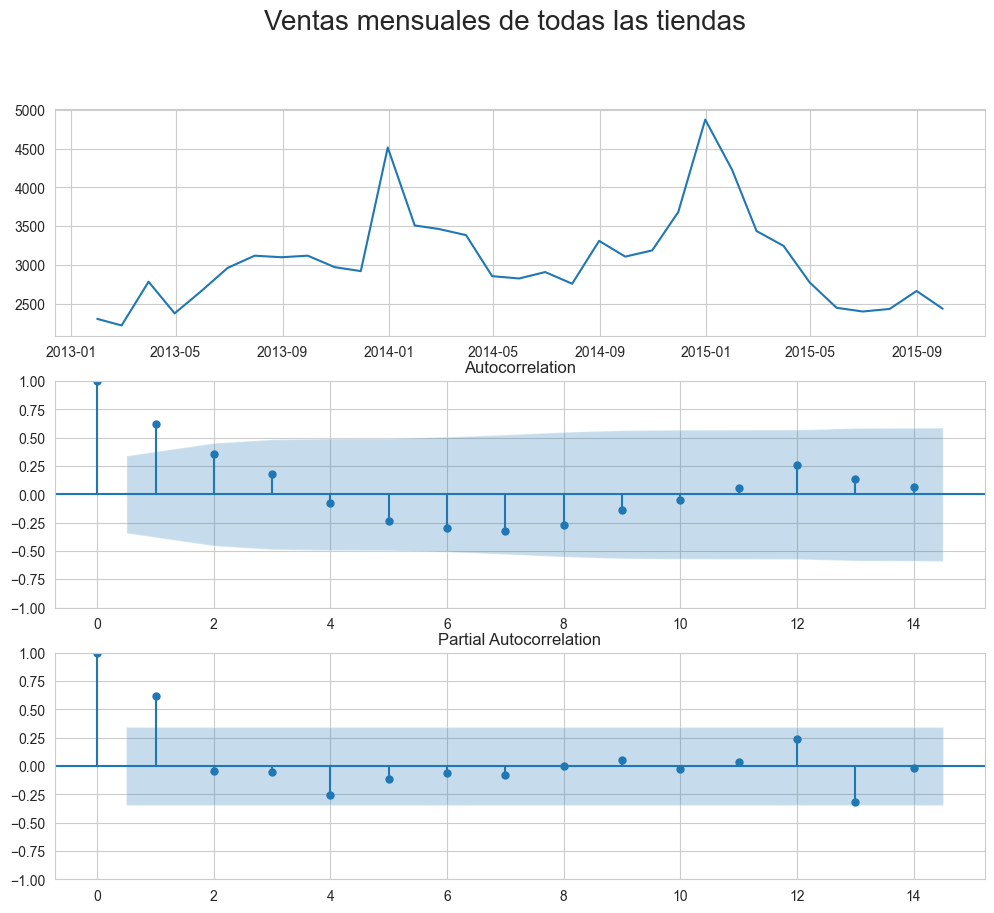

In [16]:
# Muestro una gráfica de las ventas mensuales de todas las tiendas
plot_ts_acf_pacf(y = y, title="Ventas mensuales de todas las tiendas")

## Clustering

In [17]:
# Voy a agrupar los datos en clusters para trabajar con ellos de forma mas sencilla.
# Extraigo las características con tsfresh
extracted_features = extract_features(df, column_id="unique_id", column_sort="date")

Feature Extraction: 100%|██████████| 10/10 [02:42<00:00, 16.22s/it]


In [18]:
# Ahora imputo los datos para manejar los NaN que se hayan podido introducir con tsfresh
imputed_features = impute(extracted_features)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Unnamed: 0__fft_coefficient__attr_"real"__coeff_18'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_19'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_20' ...
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'monthly_sales__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [19]:
# Ahora estandarizo las características
impute(extracted_features)
features_scaled = StandardScaler().fit_transform(imputed_features)

## Aplico K-Means

In [20]:
# Defino los números de clusters
n_clusters = 5

# Aplico K-Means
kmeans = KMeans(n_clusters = n_clusters, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Asigno los clusters al DataFrame original
unique_ids = df["unique_id"].unique()
clusters_df = pd.DataFrame({"unique_id": unique_ids, "cluster": clusters})

# Ahora ahgo un merge de todo
#df = df.merge(clusters_df, on="unique_id", how="left")

In [21]:
df = df.merge(clusters_df, on="unique_id", how="left", suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns.tolist(), axis=1, inplace=True)

In [22]:
if 'cluster' in df.columns:
    df.drop('cluster', axis=1, inplace=True)
df = df.merge(clusters_df, on="unique_id", how="left")

In [23]:
df = df.rename(columns={"unique_id": "id"})

In [24]:
df.head()

,Unnamed: 0,date,id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,cluster
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,3
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,3
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,3
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,2


## Analizo los clusters

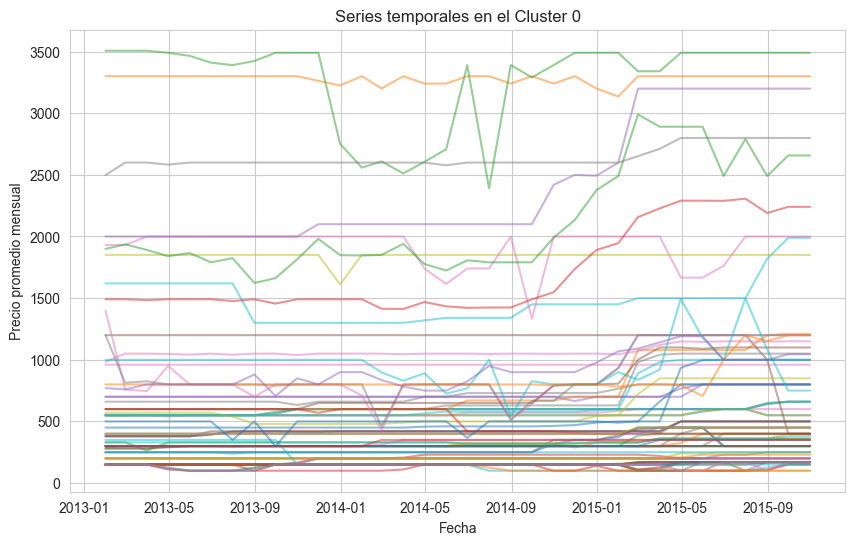

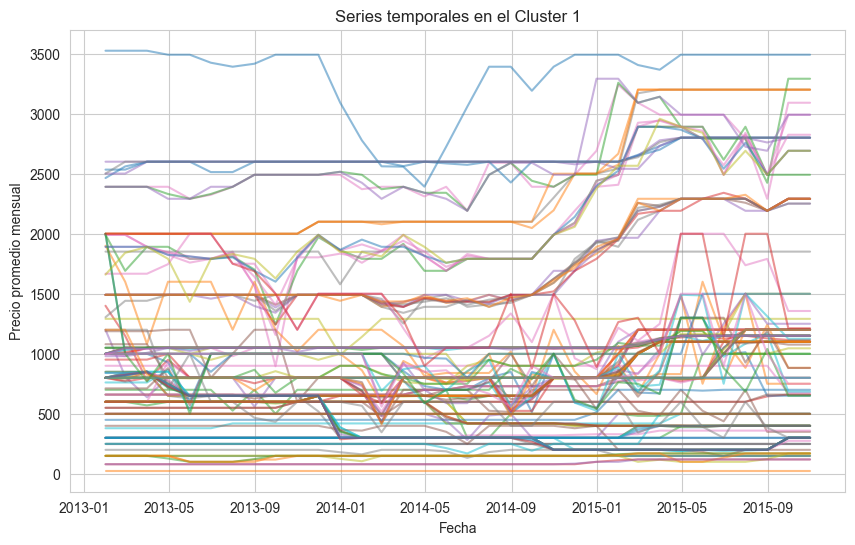

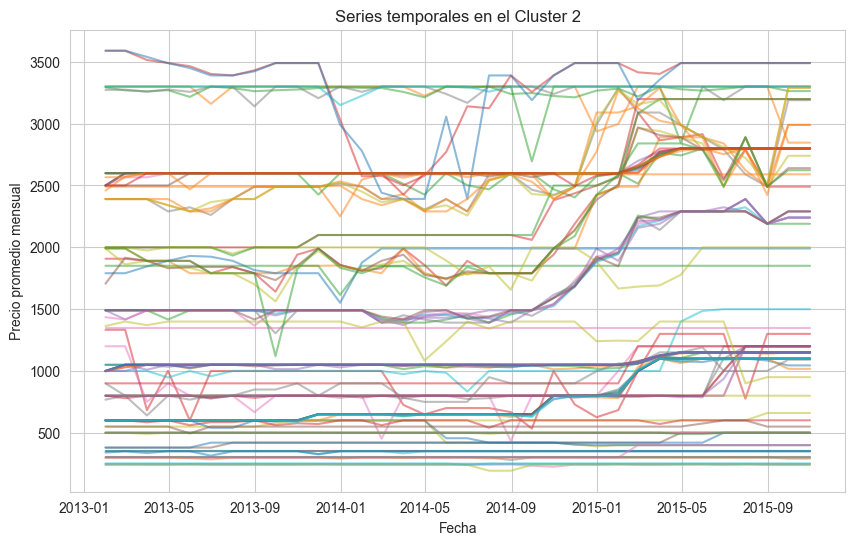

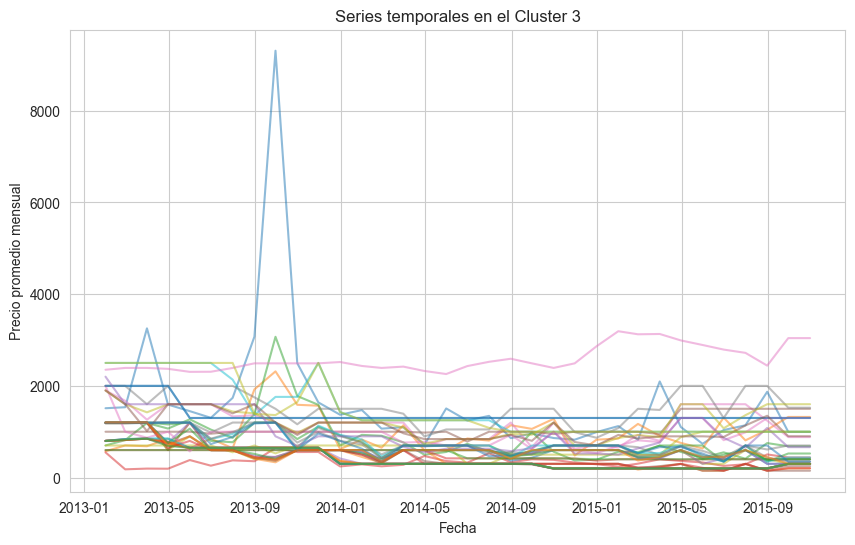

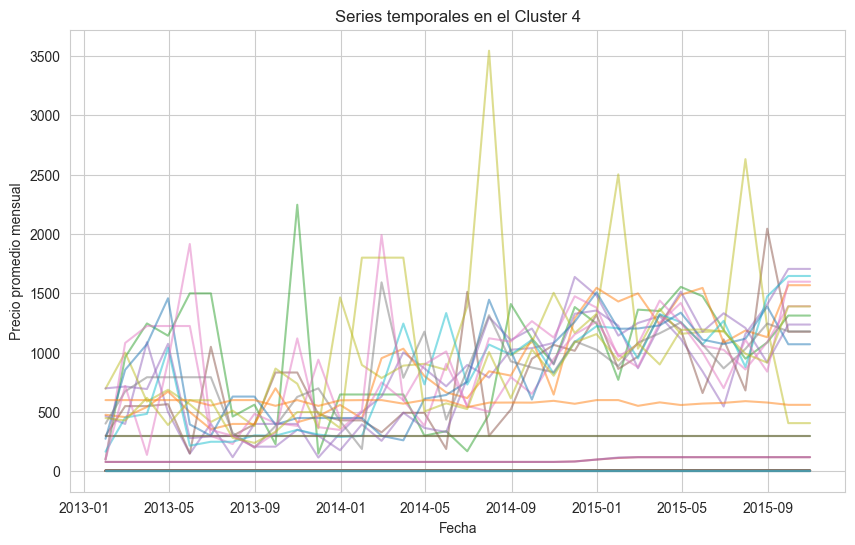

In [25]:
# Visualizo las series temporales en cada cluster
for cluster in range(n_clusters):
    plt.figure(figsize=(10, 6))
    
    # Selecciona solo las filas que pertenecen al cluster actual
    cluster_df = df[df["cluster"] == cluster]
    
    # Asegúrate de que hay datos en el cluster antes de intentar graficar
    if cluster_df.empty:
        print(f"El Cluster {cluster} está vacío.")
        continue
    
    # Grafica cada serie temporal individual en el cluster
    for unique_id in cluster_df["id"].unique():
        unique_id_series = cluster_df[cluster_df["id"] == unique_id]
        plt.plot(unique_id_series["date"], unique_id_series["monthly_average_price"], alpha=0.5)
    
    plt.title(f"Series temporales en el Cluster {cluster}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio promedio mensual")
    plt.show()


In [26]:
df.head()

,Unnamed: 0,date,id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,cluster
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,3
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,3
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,3
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,2


## Preparación de los datos después del clustering

In [27]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Creo lags
df['sales_lag_1'] = df.groupby('item_id')['monthly_sales'].shift(1)
df['sales_lag_2'] = df.groupby('item_id')['monthly_sales'].shift(2)

# Creo medias móviles
df['sales_rolling_mean_3'] = df.groupby('item_id')['monthly_sales'].shift(1).rolling(window=3).mean()

# Después de crear estas nuevas características, elimino las filas con NaN resultantes de los lags y las medias móviles
df.dropna(inplace=True)

# Definiendo el conjunto de características
features = ['cluster', 'monthly_average_price', 'month', 'year', 'sales_lag_1', 'sales_lag_2', 'sales_rolling_mean_3']


In [28]:
X = df[features]
y = df['monthly_sales']

In [29]:
# Divido el conjunto de datos de esta manera para mantener la secuencia temporal.
#  En series temporales, es crucial respetar el orden temporal para evitar el "leakage" de información futura en el conjunto de entrenamiento. En lugar de usar una división aleatoria, uso una división en función del tiempo. Esto significa que los datos más antiguos se utilizarán para el entrenamiento y los más recientes para la prueba.
split_point = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

## Entrenamiento del modelo XGBoost

In [31]:
# Inicializo y entreno el modelo XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Utilizo el error cuadrático para problemas de regresión
    n_estimators=1000, # Aumenta el número de árboles, pero la parada temprana detendrá el entrenamiento si no hay mejora
    learning_rate=0.05,
    max_depth=5, # Profundidad máxima de los árboles
    subsample=0.8,  # Fracción de muestras a utilizar para cada árbol - previene el sobreajuste
    colsample_bytree=0.8, # Fracción de características a utilizar para cada árbol
    random_state=42,
    eval_metric=["rmse", "mae"],  
    early_stopping_rounds=50
)

eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(
    X_train, y_train, 
    eval_set=eval_set, 
    verbose=True
)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")


[0]	validation_0-rmse:7.63705	validation_0-mae:5.45758	validation_1-rmse:7.69105	validation_1-mae:5.35700
[1]	validation_0-rmse:7.37574	validation_0-mae:5.28595	validation_1-rmse:7.42505	validation_1-mae:5.19335
[2]	validation_0-rmse:7.16255	validation_0-mae:5.14982	validation_1-rmse:7.19794	validation_1-mae:5.06186
[3]	validation_0-rmse:6.94067	validation_0-mae:5.00124	validation_1-rmse:6.97956	validation_1-mae:4.92746
[4]	validation_0-rmse:6.75090	validation_0-mae:4.87785	validation_1-rmse:6.78962	validation_1-mae:4.81579
[5]	validation_0-rmse:6.54815	validation_0-mae:4.74220	validation_1-rmse:6.57514	validation_1-mae:4.68133
[6]	validation_0-rmse:6.37735	validation_0-mae:4.63223	validation_1-rmse:6.40244	validation_1-mae:4.57803
[7]	validation_0-rmse:6.22943	validation_0-mae:4.53569	validation_1-rmse:6.25156	validation_1-mae:4.48597
[8]	validation_0-rmse:6.06817	validation_0-mae:4.42666	validation_1-rmse:6.09373	validation_1-mae:4.38815
[9]	validation_0-rmse:5.91756	validation_0-mae

## Predicciones del modelo

In [36]:
# Asumiendo que tienes un DataFrame 'df' desde donde puedes extraer la última fecha
last_date = df['date'].max()

# Genera fechas futuras para el período que deseas predecir
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Crea el DataFrame futuro con estas fechas
df_future = pd.DataFrame(future_dates, columns=['date'])

# Agrega las columnas 'month' y 'year', que parecen ser universales en tu análisis
df_future['month'] = df_future['date'].dt.month
df_future['year'] = df_future['date'].dt.year

# Para 'monthly_average_price', necesitarás una lógica que se ajuste a cómo calculaste esta columna inicialmente
# Aquí asumiré un valor estático o promedio como placeholder
df_future['monthly_average_price'] = 100  # Reemplaza 100 con tu lógica de cálculo o valor estimado

# Para 'cluster', necesitarás aplicar la misma lógica de clustering o asignar un cluster basado en alguna suposición
# Si usaste un modelo de clustering (como KMeans), puedes predecir el cluster para los datos futuros
# De lo contrario, puedes asignar clusters basado en suposiciones o conocimientos previos
df_future['cluster'] = 5  # Reemplaza 0 con tu lógica de asignación de clusters o predicciones de cluster

# Asegúrate de que df_future contenga solo las columnas que tu modelo necesita para hacer predicciones
X_future = df_future[features]  # 'features' debe ser la lista de características usadas para entrenar tu modelo

# Realiza las predicciones con tu modelo entrenado
future_predictions = xgb_model.predict(X_future)

# Añade las predicciones de ventas al DataFrame futuro
df_future['predicted_sales'] = future_predictions

# Visualiza las primeras filas para confirmar
print(df_future.head())



KeyError: "['sales_lag_1', 'sales_lag_2', 'sales_rolling_mean_3'] not in index"